In [1]:
import pandas as pd
import numpy as np
import dalmatian
import pickle
import os
import palettable
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

from comut import comut

In [2]:
sys.path.insert(1, '../src/')

In [3]:
from convert_names import ConvertNames

In [4]:
results_folder = '../../results/2024-03-21_comut-updates'

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# mutations
prev_mut_results_folder = '../../results/2024-02-14_mutations'
prev_cna_results_folder = '../../results/2024-01-18_gene-cna-calls/'
cohort_sheets_folder = '../../results/2024-02-05_cohort-sheets/'

# mutations and CNAs
all_mut_ccfs_maf_annotated = pd.read_pickle(os.path.join(prev_mut_results_folder, 'all_mut_ccfs_maf_bl_geneLists_evidenceLevels.pkl'))
cnas_annotated = pd.read_csv(os.path.join(prev_cna_results_folder, 'cnas_paired_all_annot_ptlevel.tsv'), sep = '\t')

# MutSig p-value combination across pathways
sig_pwys = pd.read_csv('gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/merrell/pathway_combine_mutsig_pvals/2023-09-28-2/allpaired/sig_pwys.txt', sep='\t', index_col=0)
# sig_pwys['combined_p_neglog10'] = -np.log10(sig_pwys['combined_p'])

# cohort sheets
participant_cohort_sheet = pd.read_csv(os.path.join(cohort_sheets_folder, 'paired_participant_cohort_sheet.txt'), sep='\t', index_col='participant_id')
sample_cohort_sheet = pd.read_csv(os.path.join(cohort_sheets_folder, 'paired_sample_cohort_sheet.txt'), sep='\t', index_col='collaborator_sample_id')
treatment_sheet = pd.read_csv(os.path.join(cohort_sheets_folder, 'paired_treatment_sheet_annotated.txt'), sep='\t')

pre_samples = sample_cohort_sheet[sample_cohort_sheet['pre_post'] == 'Pre']
post_samples = sample_cohort_sheet[sample_cohort_sheet['pre_post'] == 'Post']  # includes all post samples (even after multiple TKI)

# signatures - "debled" from MSI sig
H_counts = pd.read_csv('gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/merrell/signature_analyses/2023-12-14/debleed/H_matrix.tsv', sep='\t', index_col='sample')

H_counts.drop('S4-SBS54', axis = 1, inplace = True)

sig_dict = {
    'S1-SBS6': 'Clock-like',
    'S2-SBS17b': 'Capecitabine',
    'S3-SBS2': 'APOBEC' #,
    # 'S4-SBS54': 'SBS26/54 (MMRd/seq. artifact)'
}

H_counts = H_counts.rename(columns = sig_dict)

H_counts = H_counts.loc[participant_cohort_sheet.index, :]
H_counts_sum = H_counts.iloc[:, :3].sum(axis=1)
H_counts_norm = H_counts.iloc[:, :3].div(H_counts_sum, axis=0)

# Default signature colors
orange_default = '#EE8636'
red_default = '#D72627'
green_default = '#2BA02B'
# blue_default = '#1E77B4'

sig_color_dict = {s: c for s, c in zip(sig_dict.values(), [green_default, orange_default, red_default])}
# sig_color_dict = {s: c for s, c in zip(sig_dict.values(), [green_default, orange_default, red_default, blue_default])}

In [5]:
participant_list = participant_cohort_sheet.index.tolist()

all_mutations_functional_present_in_post = all_mut_ccfs_maf_annotated[(all_mut_ccfs_maf_annotated['trajectory'] != 'low_ccf') & 
                                                                         (all_mut_ccfs_maf_annotated['mutation_function_updated'] != 0)].copy()

# FGFR4: include as potential mechanism
all_mutations_functional_present_in_post.loc[all_mutations_functional_present_in_post['Hugo_Symbol'] == 'FGFR4', 'Parsons_Gene'] = True

# Mutations in BRCA-related genes
parsons_muts = all_mutations_functional_present_in_post[all_mutations_functional_present_in_post['Parsons_Gene']].copy().drop_duplicates(['Patient_ID', 'unique_mut_id'])

# CNAs - excluding GAINs for now (DeepDELs were filtered in call_gene_cnas.ipynb)
cnas_keep = ['Biallelic_Loss', 'AMP', 'HighAMP', 'FocalHighAMP', 'DeepDEL']
parsons_cnas = cnas_annotated[cnas_annotated['Parsons_Gene']].copy()
parsons_cnas = parsons_cnas[parsons_cnas['strongest_cna_filteredDELs'].isin(cnas_keep)]
parsons_cnas = parsons_cnas[parsons_cnas['classification_filteredDELs'] != 'Loss of deletion/loss']
parsons_cnas.rename(columns = {'participant_id': 'Patient_ID', 'gene': 'Hugo_Symbol'}, inplace = True)
parsons_cnas['classification_filteredDELs'] = parsons_cnas['classification_filteredDELs'].str.lower()

# remove muts for biallelic losses to not double count
biall_rm = parsons_cnas.loc[parsons_cnas['strongest_cna_filteredDELs'] == 'Biallelic_Loss', ['Patient_ID', 'Hugo_Symbol']]
parsons_muts = parsons_muts[~(parsons_muts['Patient_ID'].isin(biall_rm['Patient_ID']) & parsons_muts['Hugo_Symbol'].isin(biall_rm['Hugo_Symbol']))]

# combine
parsons = pd.concat(
    [parsons_muts, parsons_cnas[['Patient_ID', 'Hugo_Symbol', 'strongest_cna_filteredDELs', 'classification_filteredDELs', 'Parsons_Gene', 'Cancer_Gene', 'gene_set', 'OG/TSG']]]
)

In [6]:
primary_blue = '#377EB8'
dark_blue = '#11508F'
light_blue = '#009DF2'
primary_purple = '#984EA3'
primary_red = '#E41A1C'
primary_orange = '#FF7F00'
primary_yellow = '#FFFF33'
primary_brown = '#A65628'
primary_green = '#4DAF4A'
light_green = '#9FE653'
silent_gray = "#D0D0D0"
darker_gray = '#808080'

# taken from Bang Wong, 'Points of view: Color blindness'
accessible_pink = '#B92E70'  # added from Paul Tol paper
accessible_pink_l = '#CC79A7'
accessible_blue = '#0072B2'
accessible_blue_l = '#56B4E9'
accessible_green = '#009E73'
accessible_orange = '#D55E00'
accessible_orange_l = '#E69F00'
accessible_yellow = '#F0E442'

trajectory_blue = "#2D4C69"   #"#44729D"
trajectory_orange = "#E6993C" #"#D48640"
trajectory_green = "#528F45"  #"#539045"
trajectory_red = "#BD4C57"    #"#B24743"

trajectory_blue_l = "#5690C7"
trajectory_orange_l = "#E6C93C" 
trajectory_green_l = "#6DBD55"  
trajectory_red_l = "#ED5F6D"   

mut_cna_color_mapping = {
    'Gain-of-function': "#d95f02",
    'Likely Gain-of-function': "#feb37a",
    'Loss-of-function': "#64b0e3",
    'Likely Loss-of-function': "#96c9ec",
    'Hotspot': "#008000",
    'Missense_Mutation': "#00e000",
    'Nonsense_Mutation': "purple",
    'Nonstop_Mutation': "#4dbd4d",
    'Splice_Site': "#14e3c1",
    'Frame_Shift_Del': "orange",
    'Frame_Shift_Ins': "yellow",
    'In_Frame_Ins': "#ffe1b5",
    'AMP': "#ffa1a1",
    'HighAMP': "#ff6363",
    'FocalHighAMP': "#bc0000",
    'Biallelic_Loss': "dodgerblue",
    'DeepDEL': dark_blue,
    # 'Multiple': "black",
    'Absent': silent_gray
}

stage_colors = palettable.scientific.sequential.GrayC_16.mpl_colors

In [7]:
default_cols = ['sample', 'category', 'value']

# Add Resistance Type
col_name = 'resistance_type'
res_tmp = participant_cohort_sheet.loc[participant_list, [col_name]].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                   col_name: 'value'})
res_tmp['category'] = 'Resistance type'
res_mapping = {'Acquired': accessible_green, 'Intrinsic': accessible_orange}

# Add HR Status
hr_tmp = participant_cohort_sheet.loc[participant_list, ['hr_status']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                             'hr_status': 'value'})
hr_tmp['category'] = 'HR status'
hr_mapping = {'HR+': accessible_blue, 'HR-': darker_gray}

# Add Stage at Diagnosis
stage_tmp = participant_cohort_sheet.loc[participant_list, ['stage_initial']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                         'stage_initial': 'value'})
stage_tmp['category'] = 'Stage at diagnosis'

stage_mapping = {'I': stage_colors[1], 'II': stage_colors[6], 'III': stage_colors[10], 'IV': stage_colors[-1]}

# Prior AI or hormone therapy
hormone_tmp = treatment_sheet[treatment_sheet['participant_id'].isin(participant_list) &
                         (treatment_sheet['AI'] | treatment_sheet['Fulvestrant'] | treatment_sheet['Hormone Therapy'] | treatment_sheet['Endocrine Therapy']) &
                         (treatment_sheet['timing_ann'] != 'after_sampling')].copy().rename(columns={'participant_id': 'sample', 'Regimen Name': 'value'})
hormone_tmp = hormone_tmp.merge(participant_cohort_sheet.loc[participant_list, ['hr_status']], how='outer', left_on='sample', right_index=True).reset_index(drop=True)
hormone_tmp.loc[((hormone_tmp['hr_status'] == 'HR-') & (hormone_tmp['value'].isnull())), 'value'] = 'NA: HR-'
hormone_tmp.loc[((hormone_tmp['hr_status'] == 'HR+') & (hormone_tmp['value'].isnull())), 'value'] = 'None'
hormone_tmp['category'] = 'Hormone therapy'

hormone_tmp['value'] = hormone_tmp['value'].replace({
                            'Neratinib/Fulvestrant': 'Fulvestrant', 'Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Trastuzumab/Fulvestrant': 'Fulvestrant',
                            'THP/Letrozole (Paclitaxel/Trastuzumab/Pertuzumab)': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab/Pertuzumab': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab': 'Aromatase Inhibitor', 'Trastuzumab/Letrozole': 'Aromatase Inhibitor', 'Letrozole': 'Aromatase Inhibitor', 'Anastrozole': 'Aromatase Inhibitor', 'Exemestane/Trastuzumab': 'Aromatase Inhibitor'})

hormone_mapping = {'Tamoxifen': accessible_green,
                   'Fulvestrant': accessible_pink,
                   'Aromatase Inhibitor': accessible_blue, 
                   'NA: HR-': darker_gray,
                   'None': silent_gray}

In [8]:
# Level 1 mutations (known mechanisms) - collapsing into proteins (we had previously shown protein changes)
level1 = all_mutations_functional_present_in_post[all_mutations_functional_present_in_post['level_of_evidence'] == 1].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

sub_name, trunc_name = ('Subclonal mechanism', 'Truncal mechanism')

level1['category'] = 'Known mechanism'
level1['value'] = level1['Hugo_Symbol'] + '_' + level1['trajectory']

level1_muts = ['PIK3CA', 'ERBB2']

colors = [accessible_blue_l, accessible_green]
trajectories = ['growing', 'stable_mixed', 'shrinking', 'truncal']
hatches = ['//', '--', '\\\\', None] # horizontal line hatches

mut_mapping_l1 = {}
for m, c in zip(level1_muts, colors):
    for t, h in zip(trajectories, hatches):
        mut_mapping_l1[f'{m}_{t}'] = {'facecolor': c, 'hatch': h}

mut_mapping_l1['Absent'] = silent_gray

# Known and potential mechanisms
mechs = all_mutations_functional_present_in_post[(all_mutations_functional_present_in_post['Hugo_Symbol'].isin(['ESR1', 'FGFR2', 'FGFR4'])) |
                                                 (all_mutations_functional_present_in_post['level_of_evidence'] == 1)].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})
mechs['category'] = 'Resistance mechanism'
mechs['value'] = np.where(mechs['level_of_evidence'] == 1, 'Known mechanism', 'Potential mechanism')

mechs_mapping = dict(zip(['Potential mechanism', 'Known mechanism', 'Absent'],
                         [plt.cm.get_cmap('BuPu', 4)(1)[:3], plt.cm.get_cmap('BuPu', 4)(2)[:3], silent_gray]))

In [9]:
# All pathway mutations with evidence level
# Group these into pathways
pathway_combined = all_mutations_functional_present_in_post[all_mutations_functional_present_in_post['level_of_evidence'].isin([1,2,3,4,'Separate ESR1 Mutation'])].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

# Temp fix - should I patch these in the pathways file from Kate?
pathway_combined.loc[pathway_combined['Hugo_Symbol'] == 'ESR1', 'level_of_evidence'] = 2

pathway_combined['category'] = pathway_combined['gene_set'].replace({'TP53': 'TP53*', 'ESR1': 'ESR1 + regulators*', 'Cell Cycle': 'Cell cycle'})
pathway_combined['value'] = pathway_combined['trajectory'].apply(lambda x: x if x == 'truncal' else f'subclonal_{x}')
pathway_combined['value'] = pathway_combined['value'] + '_' + pathway_combined['level_of_evidence'].astype(str)

level_colors = [accessible_pink, accessible_orange, accessible_orange_l, accessible_yellow]
trajectories = ['subclonal_growing', 'subclonal_stable_mixed', 'subclonal_shrinking', 'truncal']
pathway_mut_mapping = {}
for t, h in zip(trajectories, hatches):
    for l in ['1','2','3','4']:
        pathway_mut_mapping[t+'_'+l] = {'facecolor': level_colors[int(l)-1], 'hatch': h}

pathway_mut_mapping['Absent'] = silent_gray

# Pathway counts for side bar plot
pathway_combined_counts = pathway_combined.copy()
pathway_combined_counts = pathway_combined_counts.groupby(['category', 'level_of_evidence']).size().to_frame('n_muts').reset_index()

pathway_combined_counts_wide = pathway_combined_counts.pivot(index='category', columns='level_of_evidence', values='n_muts').fillna(0).reset_index()
pathway_combined_counts_sums = pathway_combined_counts.groupby('category')['n_muts'].sum()

pathway_order = pathway_combined_counts_sums.sort_values().index

In [10]:
# Want to bold pathways that are significantly recurrently mutated via MutSig
sig_pwys[sig_pwys['combined_p_fdr'] < 0.1]

,combined_p,gene_0,p_0,gene_1,p_1,gene_2,p_2,gene_3,p_3,gene_4,...,p_80,gene_81,p_81,gene_82,p_82,gene_83,p_83,gene_84,p_84,combined_p_fdr
pathway,,,,,,,,,,,,,,,,,,,,,
TP53,4.434554e-12,TP53,1.000000e-16,CHEK2,0.122613,ATM,0.377308,MDM4,0.997797,MDM2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.878010e-11
ESR1 Regulators,4.211173e-03,ESR1,5.521965e-10,GATA3,0.008120,MTA1,0.083184,CTCF,0.091813,NCOA3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.316145e-02


In [11]:
# All mutations in Parsons genes
other = parsons.rename(columns={'Patient_ID': 'sample'})

other['category'] = other['Hugo_Symbol']
other['value'] = np.select(
    [
        other['strongest_cna_filteredDELs'].notnull(),
        other['functional_effect'].str.contains('-of-function', na=False),
        ~other['functional_effect'].str.contains('-of-function', na=False) & other['hotspot']
    ],
    [
        other['strongest_cna_filteredDELs'] + '_' + other['classification_filteredDELs'],
        other['functional_effect'] + '_' + other['trajectory'],
        'Hotspot_' + other['trajectory']
    ],
    default = other['Variant_Classification'] + '_' + other['trajectory']
)

mut_trajectories = ['growing', 'stable_mixed', 'shrinking', 'truncal', 'acquired', 'shared', 'loss', 'indeterminate']
mut_hatches = ['//', '--', '\\\\', None, '//', None, '\\\\', 'xx']
mut_mapping_other = {}
for type in mut_cna_color_mapping.keys():
    if type not in ['Absent', 'Multiple']:
        for t, h in zip(mut_trajectories, mut_hatches):
            mut_mapping_other[f'{type}_{t}'] = {'facecolor': mut_cna_color_mapping[type], 'hatch': h}

mut_mapping_other['Absent'] = mut_cna_color_mapping['Absent']

# Gene counts for side bar plot
gene_counts = other.copy().groupby(['category']).size().to_frame('n_muts').reset_index()

gene_order = gene_counts.sort_values('n_muts')['category']

## Pathway-level plot

In [12]:
resistance_plot = comut.CoMut()

# Sort participants by time on sampled TKI
participants_sorted = participant_cohort_sheet.sort_values('sampled_tki_duration', ascending = False).index
participants_sorted_no_ONC = [p[3:] for p in participants_sorted]
participants_mod_dict = {p: n for p, n in zip(participants_sorted, participants_sorted_no_ONC)}

resistance_plot.samples = participants_sorted_no_ONC

resistance_plot.add_categorical_data(res_tmp.replace(participants_mod_dict),  
                                     name = 'Resistance type',
                                     mapping=res_mapping)

resistance_plot.add_bar_data(participant_cohort_sheet['sampled_tki_duration'].reset_index().rename(columns={'participant_id': 'sample'}).replace(participants_mod_dict),
                             name = 'Days on sampled TKI',
                             ylabel = 'Days on sampled TKI',
                             mapping = {'sampled_tki_duration': stage_colors[6]},
                             bar_kwargs = {'edgecolor': 'black'})

resistance_plot.add_categorical_data(stage_tmp.replace(participants_mod_dict), 
                                     name = 'Stage at diagnosis',
                                     mapping=stage_mapping,
                                     value_order=['I', 'II', 'III', 'IV'])

resistance_plot.add_categorical_data(hr_tmp.replace(participants_mod_dict), 
                                     name = 'HR status',
                                     mapping=hr_mapping)

resistance_plot.add_categorical_data(hormone_tmp[default_cols].replace(participants_mod_dict), 
                                     name = 'Hormone treatments',
                                     mapping=hormone_mapping)

resistance_plot.add_categorical_data(level1[default_cols].replace(participants_mod_dict), 
                                     name = 'Known resistance mechanisms',
                                     # category_order = ['Subclonal mechanism', 'Truncal mechanism'], 
                                     mapping=mut_mapping_l1)

pathway_priority = [f'{x}_1' for x in ['subclonal_growing', 'truncal', 'subclonal_stable_mixed', 'subclonal_shrinking']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['subclonal_growing', 'truncal', 'subclonal_stable_mixed', 'subclonal_shrinking']]

resistance_plot.add_categorical_data(pathway_combined[default_cols].drop_duplicates().replace(participants_mod_dict), # removes many double hits, same trajectory
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(pathway_combined_counts_wide,
                                  paired_name = 'Cancer pathways',
                                  name = 'Pathway mutations',
                                  mapping = dict(zip([1,2,3,4],level_colors)),
                                  stacked = True,
                                  xlabel = '# mutations',
                                  position = 'left',
                                  bar_kwargs = {'height': 0.9})

resistance_plot.add_bar_data(H_counts_norm.reset_index().rename(columns={'participant_id': 'sample'}).replace(participants_mod_dict), name = 'Mutational signatures', mapping = sig_color_dict, stacked = True, #bar_kwargs = bar_kwargs, 
                             ylabel = 'Mutational signatures')

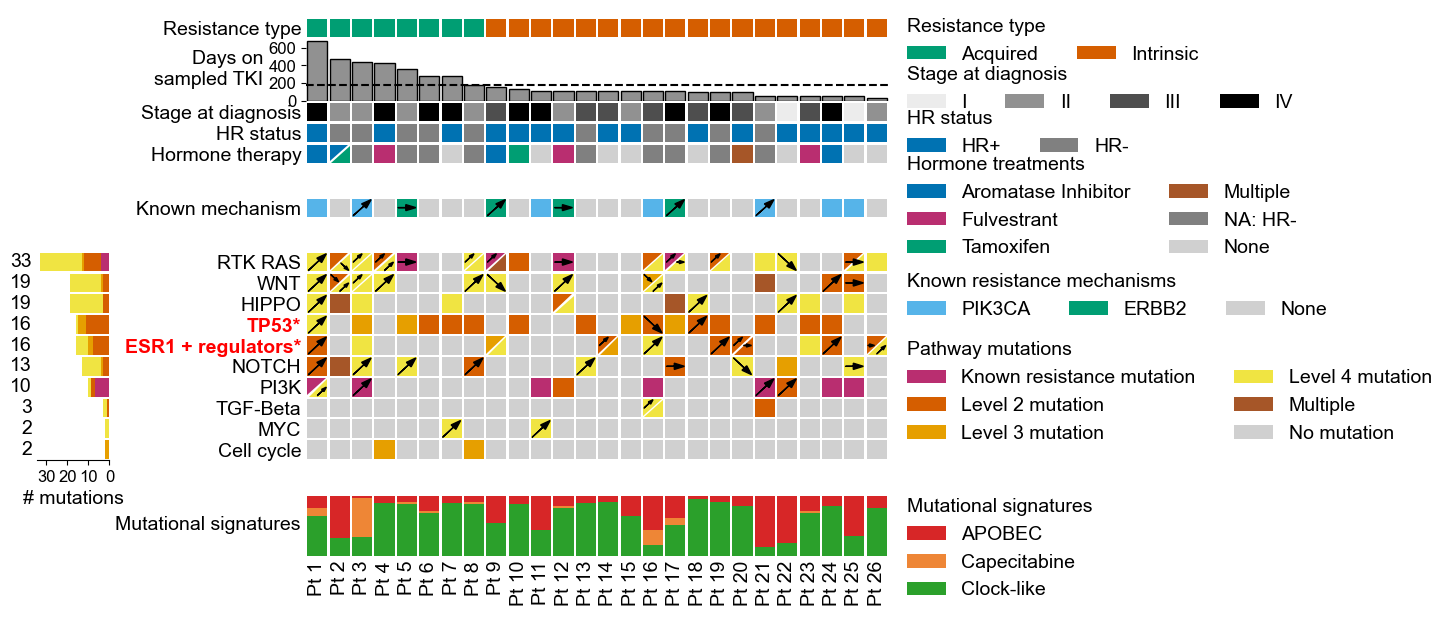

In [17]:
mpl.rcParams['hatch.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

structure = [['Resistance type', 'Days on sampled TKI', 'Stage at diagnosis', 'HR status', 'Hormone treatments'], 
    ['Known resistance mechanisms'],
    ['Cancer pathways'],
    ['Mutational signatures']]

structure = [s[::-1] for s in structure][::-1]

resistance_plot.plot_comut(figsize = (11, 7), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.3, structure = structure, subplot_hspace = 0, widths = [1, 8], wspace = 0.6)

# replace ONC IDs with Pt[1-26]
first_axis = 'Cancer pathways'
resistance_plot.axes[first_axis].set_xticklabels([f'Pt {i}' for i in np.arange(1, 27)])

# make MutSig significant pathways (TP53, ESR1 + regulators) bold
for i in [5,6]:
    resistance_plot.axes['Cancer pathways'].get_yticklabels()[i].set_weight('bold')
    resistance_plot.axes['Cancer pathways'].get_yticklabels()[i].set_color('red')

resistance_plot.axes['Days on sampled TKI'].set_yticks([0, 200, 400, 600], [0, 200, 400, 600], fontsize=12)
resistance_plot.axes['Days on sampled TKI'].set_ylabel('Days on\nsampled TKI', rotation = 'horizontal', ha = 'right', va = 'center')
resistance_plot.axes['Days on sampled TKI'].axhline(180, c = 'black', ls = '--')

resistance_plot.axes['Pathway mutations'].set_xticks([0,10,20,30], [0,10,20,30], fontsize=12)
resistance_plot.axes['Pathway mutations'].set_yticks(np.arange(0.5,10), pathway_combined_counts_sums.loc[pathway_order], ha = 'right', va = 'center')

resistance_plot.axes['Mutational signatures'].tick_params(axis = 'y', length = 0, labelleft = False)
resistance_plot.axes['Mutational signatures'].set_ylabel('Mutational signatures', rotation = 'horizontal', ha = 'right', va = 'center')

hormone_legend_order = ['Aromatase Inhibitor', 'Fulvestrant', 'Tamoxifen', 'Multiple', 'NA: HR-', 'None'] 

pathway_legend_ignore = ['subclonal_growing_1', 'subclonal_stable_mixed_1', 'subclonal_shrinking_2', 'subclonal_growing_2', 'subclonal_shrinking_3', 'subclonal_stable_mixed_2', 'subclonal_growing_3', 'subclonal_growing_4', 'subclonal_stable_mixed_4', 'subclonal_shrinking_4']

pathway_legend_rename_dict = {
    'truncal_4': 'Level 4 mutation',
    'truncal_3': 'Level 3 mutation',
    'truncal_2': 'Level 2 mutation',
    'truncal_1': 'Known resistance mutation',
    'Absent': 'No mutation'
}

pathway_legend_order = [
    'Known resistance mutation', 'Level 2 mutation', 'Level 3 mutation', 'Level 4 mutation', 'Multiple', 'No mutation'
]

level1_legend_rename_dict = {
    'PIK3CA_truncal': 'PIK3CA',
    'ERBB2_stable_mixed': 'ERBB2',
    'Absent': 'None'
}

level1_legend_order = ['PIK3CA', 'ERBB2', 'None']

level1_legend_ignore = ['ERBB2_growing', 'PIK3CA_growing']

mut_legend_rename_dict = {
    'Gain-of-function_growing': 'Gain-of-function',
    'Hotspot_growing': 'Hotspot',
    'In_Frame_Ins_growing': 'In-frame insertion',
    'Likely Gain-of-function_truncal': 'Likely gain-of-function',
    'Likely Loss-of-function_truncal': 'Likely loss-of-function',
    'Missense_Mutation_growing': 'Missense',
    'Nonsense_Mutation_truncal': 'Nonsense',
    'Nonstop_Mutation_growing': 'Nonstop',
    'AMP_shared': 'Amplification',
    'Biallelic_Loss_shared': 'Biallelic inactivation',
    'DeepDEL_indeterminate': 'Homozygous deletion',
    'FocalHighAMP_shared': 'Focal high amplification',
    'HighAMP_shared': 'High amplification',
    'Absent': 'No alteration'
}

mut_legend_ignore = [
    'Likely Loss-of-function_growing',
    'Missense_Mutation_shrinking',
    'Missense_Mutation_stable_mixed',
    'Missense_Mutation_truncal',
    'AMP_acquired',
    'AMP_loss',
    'Biallelic_Loss_acquired',
    'FocalHighAMP_acquired',
    'FocalHighAMP_indeterminate',
    'FocalHighAMP_loss',
    'HighAMP_acquired',
    'HighAMP_indeterminate',
    'HighAMP_loss'
]

mut_legend_order = [
    'Focal high amplification',
    'High amplification',
    'Amplification',
    'Biallelic inactivation',
    'Homozygous deletion',
    'Gain-of-function',
    'Likely gain-of-function',
    'Likely loss-of-function',
    'Hotspot',
    'Missense',
    'Nonsense',
    'Nonstop',
    'In-frame insertion',
    'Multiple',
    'No alteration'
]

resistance_plot.add_axis_legend(name = 'Resistance type',
                                ncol = 2,
                                title = 'Resistance type',
                                bbox_to_anchor = (1,1.8))

resistance_plot.add_axis_legend(name = 'Stage at diagnosis',
                                ncol = 4,
                                title = 'Stage at diagnosis',
                                bbox_to_anchor = (1,3.5))

resistance_plot.add_axis_legend(name = 'HR status',
                                ncol = 2,
                                title = 'HR status',
                                bbox_to_anchor = (1,2.4))

resistance_plot.add_axis_legend(name = 'Hormone treatments',
                                ncol = 2,
                                title = 'Hormone treatments',
                                order = hormone_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor = (1,1.2))

resistance_plot.add_axis_legend(name = 'Known resistance mechanisms',
                                ignored_values = level1_legend_ignore,
                                ncol = 3,
                                title = 'Known resistance mechanisms',
                                rename = level1_legend_rename_dict,
                                order = level1_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor=(1,-1.8))

resistance_plot.add_axis_legend(name = 'Cancer pathways',
                                ignored_values = pathway_legend_ignore,
                                ncol = 2,
                                rename = pathway_legend_rename_dict,
                                order = pathway_legend_order,
                                title = 'Pathway mutations',
                                bbox_to_anchor=(1, 0.65))

resistance_plot.add_axis_legend(name = 'Mutational signatures',
                                ncol = 1,
                                title = 'Mutational signatures',
                                bbox_to_anchor=(1, 1.2))

# replacing hatches with arrows
gene_order = gene_order.reset_index(drop = True)

## known mechanisms
for i in range(len(participants_sorted)):
    tmp_i = level1[level1['sample'] == participants_sorted[i]].reset_index()
    if len(tmp_i) > 0:
        trj = tmp_i.loc[0, 'trajectory']
        if trj == 'growing':
            resistance_plot.axes['Known resistance mechanisms'].arrow(x = i + 0.1, y = 0.1, dx = 0.8, dy = 0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
        elif trj == 'shrinking':
            resistance_plot.axes['Known resistance mechanisms'].arrow(x = i + 0.1, y = 0.9, dx = 0.8, dy = -0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
        elif trj == 'stable_mixed':
            resistance_plot.axes['Known resistance mechanisms'].arrow(x = i + 0.1, y = 0.5, dx = 0.8, dy = 0, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
## pathways
    tmp_i = pathway_combined[pathway_combined['sample'] == participants_sorted[i]]
    for j in range(len(pathway_order)):
        tmp_ij = tmp_i[tmp_i['category'] == pathway_order[j]].reset_index()
        if (len(tmp_ij) == 1 and tmp_ij.loc[0, 'trajectory'] != 'truncal') or (len(tmp_ij) == 2 and tmp_ij['trajectory'].nunique() == 1 and ~tmp_ij['trajectory'].str.contains('truncal').any()):
            trj = tmp_ij.loc[0, 'trajectory']
            if trj == 'growing':
                resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.1, dx = 0.8, dy = 0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
            elif trj == 'shrinking':
                resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.8, dy = -0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
            elif trj == 'stable_mixed':
                resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.8, dy = 0, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
        elif len(tmp_ij) == 2:
            tmp_ij['value_categ'] = pd.Categorical(tmp_ij['value'], ordered = True, categories = pathway_value_order)
            tmp_ij = tmp_ij.sort_values('value_categ').reset_index()
            for k, row in tmp_ij.iterrows():
                trj = row['trajectory']
                if k == 0: # left triangle
                    if trj == 'growing':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'shrinking':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'stable_mixed':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.3, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                else: # right triangle
                    if trj == 'growing':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.5, y = j + 0.1, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'shrinking':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.45, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'stable_mixed':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.5, dx = 0.35, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
        elif tmp_ij['value'].nunique() == 2:
            trjs = sorted(list(set(tmp_ij['value'].unique())), key = pathway_value_order.index)
            for k, trj in enumerate(trjs):
                if k == 0: # left triangle
                    if 'growing' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'shrinking' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'stable_mixed' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.3, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                else: # right triangle
                    if 'growing' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.5, y = j + 0.1, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'shrinking' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.45, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'stable_mixed' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.5, dx = 0.35, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
# edge case - level 1 mutation (prioritized) with multiple others
resistance_plot.axes['Cancer pathways'].arrow(x = 8 + 0.1, y = 9 + 0.5, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')

plt.show()

In [18]:
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_paired.2024-03-21.pdf'), bbox_inches='tight')
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_paired.2024-03-21.png'), dpi=450, bbox_inches='tight')

## Gene-level plot

In [15]:
resistance_plot = comut.CoMut()

resistance_plot.samples = participants_sorted_no_ONC

resistance_plot.add_categorical_data(res_tmp.replace(participants_mod_dict),  
                                     name = 'Resistance type',
                                     mapping=res_mapping)

resistance_plot.add_bar_data(participant_cohort_sheet['sampled_tki_duration'].reset_index().rename(columns={'participant_id': 'sample'}).replace(participants_mod_dict),
                             name = 'Days on sampled TKI',
                             ylabel = 'Days on sampled TKI',
                             mapping = {'sampled_tki_duration': stage_colors[6]},
                             bar_kwargs = {'edgecolor': 'black'})

resistance_plot.add_categorical_data(stage_tmp.replace(participants_mod_dict), 
                                     name = 'Stage at diagnosis',
                                     mapping=stage_mapping,
                                     value_order=['I', 'II', 'III', 'IV'])

resistance_plot.add_categorical_data(hr_tmp.replace(participants_mod_dict), 
                                     name = 'HR status',
                                     mapping=hr_mapping)

resistance_plot.add_categorical_data(hormone_tmp[default_cols].replace(participants_mod_dict), 
                                     name = 'Hormone treatments',
                                     mapping=hormone_mapping)

resistance_plot.add_categorical_data(mechs[default_cols].replace(participants_mod_dict),
                                     name = 'Resistance mechanism',
                                     priority = 'Known mechanism',
                                     mapping = mechs_mapping)

resistance_plot.add_categorical_data(other[default_cols].replace(participants_mod_dict),
                                     name = 'Genes',
                                     tick_style = 'italic',
                                     category_order = gene_order,
                                     mapping = mut_mapping_other)

resistance_plot.add_side_bar_data(gene_counts,
                                  paired_name = 'Genes',
                                  name = 'Gene mutations',
                                  xlabel = '# mutations',
                                  position = 'left',
                                  bar_kwargs = {'height': 0.9})

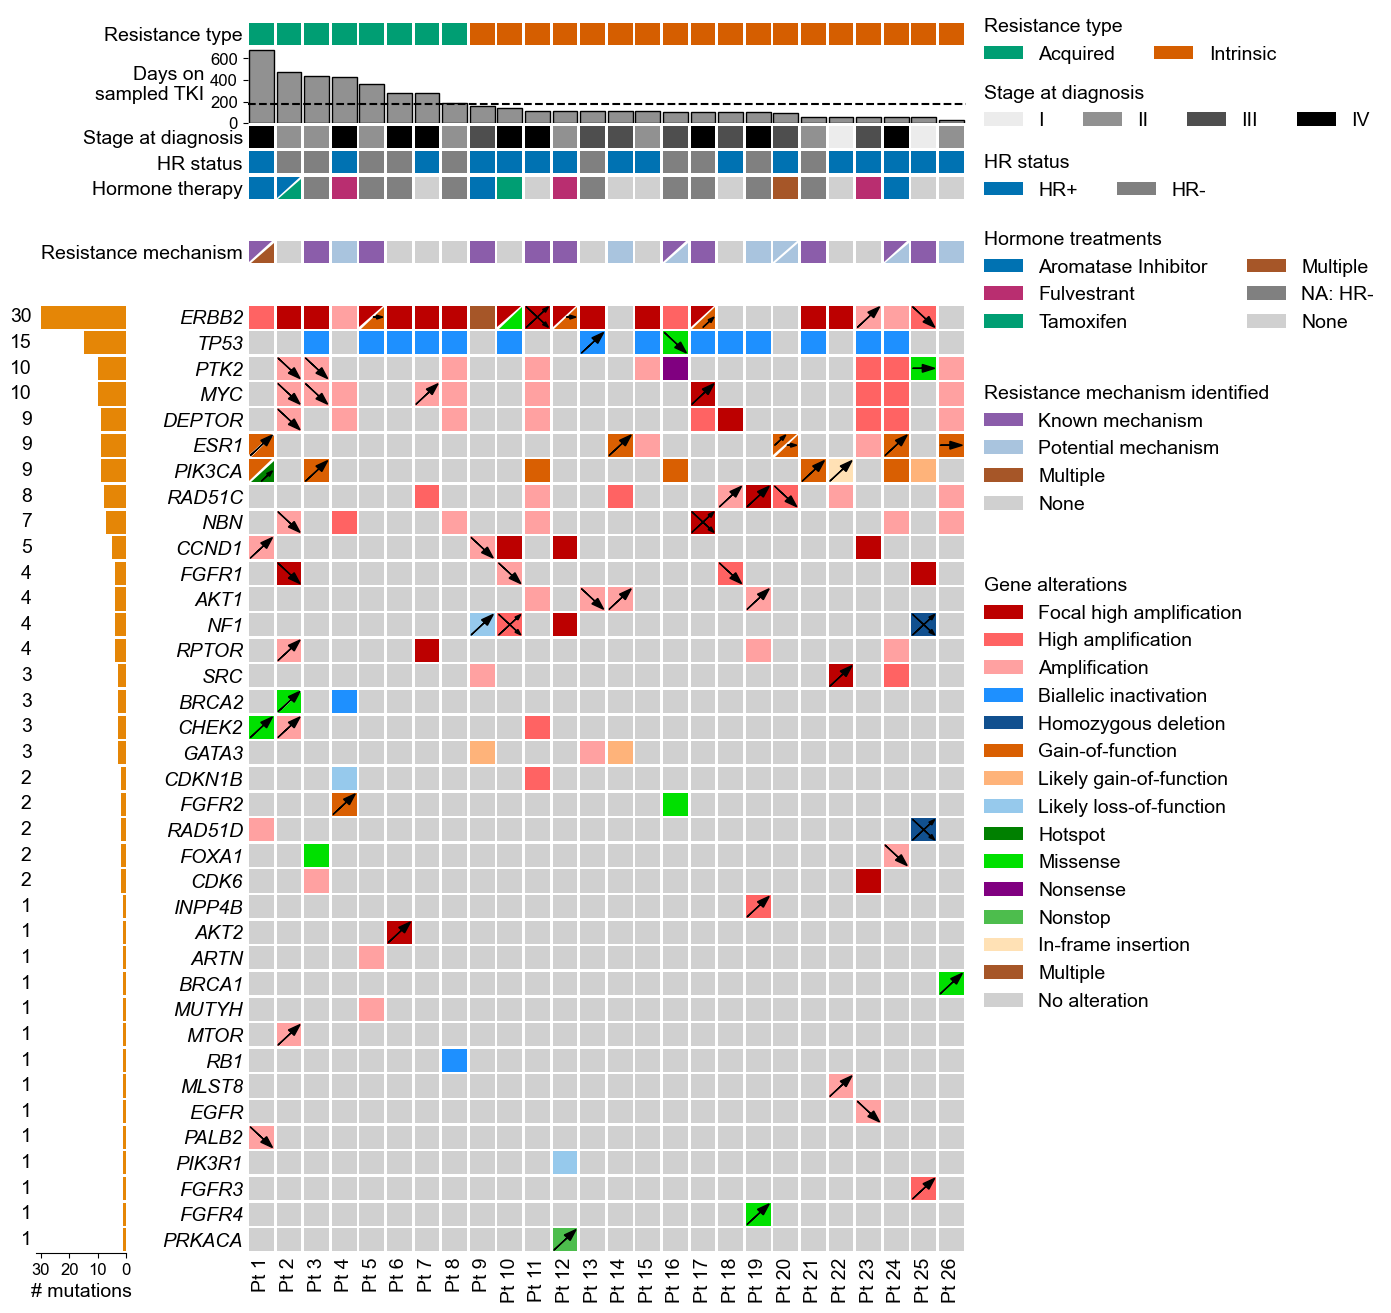

In [16]:
mpl.rcParams['hatch.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

structure = [['Resistance type', 'Days on sampled TKI', 'Stage at diagnosis', 'HR status', 'Hormone treatments'], 
            ['Resistance mechanism'],
            ['Genes']]

structure = [s[::-1] for s in structure][::-1]

resistance_plot.plot_comut(figsize = (12, 16), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.1, structure = structure, subplot_hspace = 0, widths = [1, 8], wspace = 0.3)

# replace ONC IDs with Pt[1-26]
first_axis = 'Genes'
resistance_plot.axes[first_axis].set_xticklabels([f'Pt {i}' for i in np.arange(1, 27)])

resistance_plot.axes['Days on sampled TKI'].set_yticks([0, 200, 400, 600], [0, 200, 400, 600], fontsize=12)
resistance_plot.axes['Days on sampled TKI'].set_ylabel('Days on\nsampled TKI', rotation = 'horizontal', ha = 'right', va = 'center')
resistance_plot.axes['Days on sampled TKI'].axhline(180, c = 'black', ls = '--')

resistance_plot.axes['Gene mutations'].set_xticks([0,10,20,30], [0,10,20,30], fontsize=12)
resistance_plot.axes['Gene mutations'].set_yticks(np.arange(0.5,len(gene_counts)), gene_counts.set_index('category').loc[gene_order, 'n_muts'], ha = 'right', va = 'center')

hormone_legend_order = ['Aromatase Inhibitor', 'Fulvestrant', 'Tamoxifen', 'Multiple', 'NA: HR-', 'None']

mech_legend_rename_dict = {'Absent': 'None'}
mech_legend_order = ['Known mechanism', 'Potential mechanism', 'Multiple', 'Absent']

mut_legend_rename_dict = {
    'Gain-of-function_growing': 'Gain-of-function',
    'Hotspot_growing': 'Hotspot',
    'In_Frame_Ins_growing': 'In-frame insertion',
    'Likely Gain-of-function_truncal': 'Likely gain-of-function',
    'Likely Loss-of-function_truncal': 'Likely loss-of-function',
    'Missense_Mutation_growing': 'Missense',
    'Nonsense_Mutation_truncal': 'Nonsense',
    'Nonstop_Mutation_growing': 'Nonstop',
    'AMP_shared': 'Amplification',
    'Biallelic_Loss_shared': 'Biallelic inactivation',
    'DeepDEL_indeterminate': 'Homozygous deletion',
    'FocalHighAMP_shared': 'Focal high amplification',
    'HighAMP_shared': 'High amplification',
    'Absent': 'No alteration'
}
mut_legend_ignore = [
    'Likely Loss-of-function_growing',
    'Gain-of-function_stable_mixed',
    'Gain-of-function_truncal',
    'Missense_Mutation_shrinking',
    'Missense_Mutation_stable_mixed',
    'Missense_Mutation_truncal',
    'AMP_acquired',
    'AMP_loss',
    'Biallelic_Loss_acquired',
    'FocalHighAMP_acquired',
    'FocalHighAMP_indeterminate',
    'FocalHighAMP_loss',
    'HighAMP_acquired',
    'HighAMP_indeterminate',
    'HighAMP_loss'
]
mut_legend_order = [
    'Focal high amplification',
    'High amplification',
    'Amplification',
    'Biallelic inactivation',
    'Homozygous deletion',
    'Gain-of-function',
    'Likely gain-of-function',
    'Likely loss-of-function',
    'Hotspot',
    'Missense',
    'Nonsense',
    'Nonstop',
    'In-frame insertion',
    'Multiple',
    'No alteration'
]

resistance_plot.add_axis_legend(name = 'Resistance type',
                                ncol = 2,
                                title = 'Resistance type',
                                bbox_to_anchor = (1,1.8))

resistance_plot.add_axis_legend(name = 'Stage at diagnosis',
                                ncol = 4,
                                title = 'Stage at diagnosis',
                                bbox_to_anchor = (1,3.2))

resistance_plot.add_axis_legend(name = 'HR status',
                                ncol = 2,
                                title = 'HR status',
                                bbox_to_anchor = (1,1.5))

resistance_plot.add_axis_legend(name = 'Hormone treatments',
                                ncol = 2,
                                title = 'Hormone treatments',
                                order = hormone_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor = (1,-0.5))

resistance_plot.add_axis_legend(name = 'Resistance mechanism',
                                ncol = 1,
                                title = 'Resistance mechanism identified',
                                rename = mech_legend_rename_dict,
                                order = mech_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor=(1,-4))

resistance_plot.add_axis_legend(name = 'Genes',
                                ignored_values = mut_legend_ignore,
                                ncol = 1,
                                title = 'Gene alterations',
                                rename = mut_legend_rename_dict,
                                order = mut_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor=(1, 0.73))

# replacing hatches with arrows
gene_order = gene_order.reset_index(drop = True)

for i in range(len(participants_sorted)):
    tmp_i = other[other['sample'] == participants_sorted[i]]
    for j in range(len(gene_order)):
        tmp_ij = tmp_i[tmp_i['category'] == gene_order[j]].reset_index()
        if (len(tmp_ij) == 1 and 'truncal' not in tmp_ij.loc[0, 'value'] and 'shared' not in tmp_ij.loc[0, 'value']) or (len(tmp_ij) == 2 and tmp_ij['value'].nunique() == 1 and ~tmp_ij['value'].str.contains('truncal|shared').any()):
            trj = tmp_ij.loc[0, 'value']
            if 'growing' in trj or 'acquired' in trj:
                resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.1, dx = 0.8, dy = 0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
            elif 'shrinking' in trj or 'loss' in trj:
                resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.8, dy = -0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
            elif 'stable_mixed' in trj:
                resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.8, dy = 0, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
            elif 'indeterminate' in trj:
                resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.1, dx = 0.8, dy = 0.8, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.8, dy = -0.8, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
        elif len(tmp_ij) == 2:
            tmp_ij = tmp_ij.sort_values('value').reset_index()
            for k, row in tmp_ij.iterrows():
                trj = row['value']
                if k == 0: # left triangle
                    if 'growing' in trj or 'acquired' in trj:
                        resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'shrinking' in trj or 'loss' in trj:
                        resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'stable_mixed' in trj:
                        resistance_plot.axes['Genes'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.3, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                else: # right triangle
                    if 'growing' in trj or 'acquired' in trj:
                        resistance_plot.axes['Genes'].arrow(x = i + 0.5, y = j + 0.1, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'shrinking' in trj or 'loss' in trj:
                        resistance_plot.axes['Genes'].arrow(x = i + 0.55, y = j + 0.45, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'stable_mixed' in trj:
                        resistance_plot.axes['Genes'].arrow(x = i + 0.55, y = j + 0.5, dx = 0.35, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
plt.show()

In [17]:
resistance_plot.figure.savefig(os.path.join(results_folder, 'gene_plot_paired.2024-03-21.pdf'), bbox_inches='tight')
resistance_plot.figure.savefig(os.path.join(results_folder, 'gene_plot_paired.2024-03-21.png'), dpi=450, bbox_inches='tight')

# Unpaired Cohort

We'll use the legend from the combined plot but will also make separate plots for the pre- and post-TKI cohorts.

## Combined

In [18]:
prev_mut_results_folder = '../../results/2024-02-12_mutations'

In [19]:
all_mut_ccfs_maf_annotated = pd.read_csv(os.path.join(prev_mut_results_folder, 'all_mut_ccfs_maf_annotated_geneLists_evidenceLevels_unpaired.txt'), sep='\t', low_memory=False)

# MutSig p-value combination across pathways
sig_pwys_exposed = pd.read_csv('gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/merrell/pathway_combine_mutsig_pvals/2023-09-28-2/exposed/sig_pwys.txt', sep='\t', index_col=0)
sig_pwys_nonexposed = pd.read_csv('gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/merrell/pathway_combine_mutsig_pvals/2023-09-28-2/nonexposed/sig_pwys.txt', sep='\t', index_col=0)

participant_cohort_sheet = pd.read_csv(os.path.join(cohort_sheets_folder, 'unpaired_participant_cohort_sheet.txt'), sep='\t', index_col='participant_id')
sample_cohort_sheet = pd.read_csv(os.path.join(cohort_sheets_folder, 'unpaired_sample_cohort_sheet.txt'), sep='\t', index_col=0)
treatment_sheet = pd.read_csv(os.path.join(cohort_sheets_folder, 'unpaired_treatment_sheet_annotated.txt'), sep='\t')

# signatures - "debled" from MSI sig
H_counts = pd.read_csv('gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/merrell/signature_analyses/2023-12-14/debleed/H_matrix.tsv', sep='\t', index_col='sample')

sig_dict = {
    'S1-SBS6': 'Clock-like',
    'S2-SBS17b': 'Capecitabine',
    'S3-SBS2': 'APOBEC',
    'S4-SBS54': 'MMRd'
}

H_counts = H_counts.rename(columns = sig_dict)

H_counts = H_counts.loc[participant_cohort_sheet.index, :]
H_counts_sum = H_counts.iloc[:, :4].sum(axis=1)
H_counts_norm = H_counts.iloc[:, :4].div(H_counts_sum, axis=0)

# Default signature colors
orange_default = '#EE8636'
red_default = '#D72627'
green_default = '#2BA02B'
blue_default = '#1E77B4'

sig_color_dict = {s: c for s, c in zip(sig_dict.values(), [green_default, orange_default, red_default, blue_default])}

In [20]:
participant_list = participant_cohort_sheet.index.tolist()

all_mutations_functional = all_mut_ccfs_maf_annotated[(all_mut_ccfs_maf_annotated['mutation_function_updated'] != 0) &
                                                      (all_mut_ccfs_maf_annotated['postDP_ccf_mode'] >= 0.1)].copy()

all_mutations_functional.loc[all_mutations_functional['level_of_evidence'] == 'Separate ESR1 Mutation', 'level_of_evidence'] = 2
all_mutations_functional['level_of_evidence'] = pd.to_numeric(all_mutations_functional['level_of_evidence'])

# FGFR4: include as potential mechanism
all_mutations_functional.loc[all_mutations_functional['Hugo_Symbol'] == 'FGFR4', 'Parsons_Gene'] = True

In [21]:
default_cols = ['sample', 'category', 'value']

# Add cohort
cohort_tmp = participant_cohort_sheet.loc[participant_list, ['Cohort']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                   'Cohort': 'value'})
cohort_tmp['category'] = 'Cohort'
cohort_mapping = {'Exposed': dark_blue, 'Non-exposed': light_blue}

# Add HR Status
hr_tmp = participant_cohort_sheet.loc[participant_list, ['hr_status']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                             'hr_status': 'value'})
hr_tmp['category'] = 'HR status'
hr_mapping = {'HR+': accessible_blue, 'HR-': darker_gray,
             'HR Unknown': silent_gray}

# Add Stage at Diagnosis
stage_tmp = participant_cohort_sheet.loc[participant_list, ['stage_initial']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                         'stage_initial': 'value'})
stage_tmp['category'] = 'Stage at diagnosis'
stage_mapping = {'I': stage_colors[1], 'II': stage_colors[6], 'III': stage_colors[10], 'IV': stage_colors[-1],
                'Unknown': silent_gray}

# Prior AI or hormone therapy
hormone_tmp = treatment_sheet[treatment_sheet['participant_id'].isin(participant_list) &
                         (treatment_sheet['AI'] | treatment_sheet['Fulvestrant'] | treatment_sheet['Hormone Therapy'] | treatment_sheet['Endocrine Therapy']) &
                         (treatment_sheet['timing_ann'] != 'after_sampling')].copy().rename(columns={'participant_id': 'sample', 'Regimen Name': 'value'})
hormone_tmp = hormone_tmp.merge(participant_cohort_sheet.loc[participant_list, ['hr_status']], how='outer', left_on='sample', right_index=True).reset_index(drop=True)
hormone_tmp.loc[((hormone_tmp['hr_status'] == 'HR-') & (hormone_tmp['value'].isnull())), 'value'] = 'NA: HR-'
hormone_tmp.loc[(((hormone_tmp['hr_status'] == 'HR+') | (hormone_tmp['hr_status'] == 'HR Unknown')
                 ) & (hormone_tmp['value'].isnull())), 'value'] = 'None'
hormone_tmp['category'] = 'Hormone therapy'

hormone_tmp['value'] = hormone_tmp['value'].replace({
    'Tamoxifen ': 'Tamoxifen', 'Tamoxifen/Trastuzumab': 'Tamoxifen',
    'Neratinib/Fulvestrant': 'Fulvestrant', 'Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Trastuzumab/Fulvestrant': 'Fulvestrant', 'Fulvestrant/Alpelisib/Trastuzumab': 'Fulvestrant', 'Lapatinib/Trastuzumab/Fulvestrant->Capecitabine': 'Fulvestrant', 'Lapatinib/Fulvestrant': 'Fulvestrant', 'Neratinib/Fulvestrant': 'Fulvestrant',
    'Letrozole/Trastuzumab/Pertuzumab': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab': 'Aromatase Inhibitor', 'Trastuzumab/Letrozole': 'Aromatase Inhibitor', 'Letrozole': 'Aromatase Inhibitor', 'Anastrozole': 'Aromatase Inhibitor', 'Anastrozole/Trastuzumab': 'Aromatase Inhibitor', 'Anastrozole/Letrozole': 'Aromatase Inhibitor', 'Exemestane/Trastuzumab': 'Aromatase Inhibitor', 'Exemestane/Everolimus': 'Aromatase Inhibitor', 'Exemestane': 'Aromatase Inhibitor', 'Abemaciclib/Letrozole/Trastuzumab': 'Aromatase Inhibitor', 'Aromatase Inhibitor/Trastuzumab': 'Aromatase Inhibitor', 'Docetaxel/Carboplatin/Trastuzumab/Letrozole': 'Aromatase Inhibitor', 'Exemestane/Trastuzumab': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab/BYL (PI3kinase inhibitor)': 'Aromatase Inhibitor',
    'Bicalutamide': 'Antiandrogen'
})

hormone_mapping = {'Tamoxifen': accessible_green,
                   'Fulvestrant': accessible_pink,
                   'Aromatase Inhibitor': accessible_blue,
                   'Antiandrogen': accessible_orange_l,
                   'NA: HR-': darker_gray,
                   'None': silent_gray}

In [22]:
# Known and potential mechanisms
mechs = all_mutations_functional[(all_mutations_functional['Hugo_Symbol'].isin(['ESR1', 'FGFR2', 'FGFR4'])) |
                                 (all_mutations_functional['level_of_evidence'] == 1)].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

mechs['category'] = 'Resistance mechanism'
mechs['value'] = np.where(mechs['level_of_evidence'] == 1, 'Known mechanism', 'Potential mechanism')

mechs_mapping = dict(zip(['Potential mechanism', 'Known mechanism', 'Absent'],
                         [plt.cm.get_cmap('BuPu', 4)(1)[:3], plt.cm.get_cmap('BuPu', 4)(2)[:3], silent_gray]))

In [23]:
sig_pwys_exposed[sig_pwys_exposed['combined_p_fdr'] < 0.1]

,combined_p,gene_0,p_0,gene_1,p_1,gene_2,p_2,gene_3,p_3,gene_4,...,p_80,gene_81,p_81,gene_82,p_82,gene_83,p_83,gene_84,p_84,combined_p_fdr
pathway,,,,,,,,,,,,,,,,,,,,,
PI3K,3.103742e-06,PIK3CA,1.110223e-16,PTEN,0.006458,TSC2,0.020370,RPS6KB1,0.028102,PPP2R1A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.707058e-05
TP53,2.553057e-13,TP53,1.000000e-16,ATM,0.005109,CHEK2,0.355887,RPS6KA3,0.999258,MDM4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.808362e-12


In [24]:
sig_pwys_nonexposed[sig_pwys_nonexposed['combined_p_fdr'] < 0.1]

,combined_p,gene_0,p_0,gene_1,p_1,gene_2,p_2,gene_3,p_3,gene_4,...,p_80,gene_81,p_81,gene_82,p_82,gene_83,p_83,gene_84,p_84,combined_p_fdr
pathway,,,,,,,,,,,,,,,,,,,,,
TP53,3.101290e-11,TP53,1.000000e-16,ATM,0.429317,RPS6KA3,0.995856,MDM2,0.998065,CHEK2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.411419e-10


In [25]:
# All pathway mutations with evidence level
# Group these into pathways
pathway_combined = all_mutations_functional[all_mutations_functional['level_of_evidence'].isin([1,2,3,4])].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

pathway_combined['category'] = pathway_combined['gene_set'].replace({'TP53': 'TP53*†', 'PI3K': 'PI3K*', 'ESR1': 'ESR1 + regulators', 'Cell Cycle': 'Cell cycle'})
pathway_combined['value'] = pathway_combined['clonal_status'] + '_' + pathway_combined['level_of_evidence'].astype(int).astype(str)

level_colors = [accessible_pink, accessible_orange, accessible_orange_l, accessible_yellow]
pathway_mut_mapping = {}
for t, h in zip(['clonal', 'subclonal'], [None, 'xxx']):
    for l in ['1','2','3','4']:
        pathway_mut_mapping[t+'_'+l] = {'facecolor': level_colors[int(l)-1], 'hatch': h}

pathway_mut_mapping['Absent'] = silent_gray

# Pathway counts for side bar plot
pathway_combined_counts = pathway_combined.copy()
pathway_combined_counts = pathway_combined_counts.groupby(['category', 'level_of_evidence']).size().to_frame('n_muts').reset_index()

pathway_combined_counts_wide = pathway_combined_counts.pivot(index='category', columns='level_of_evidence', values='n_muts').fillna(0).reset_index()
pathway_combined_counts_sums = pathway_combined_counts.groupby('category')['n_muts'].sum()

pathway_order = pathway_combined_counts_sums.sort_values().index

In [26]:
mechs_sort_values = mechs[['sample', 'value', 'category']].\
    replace({'Known mechanism': 1, 'Potential mechanism': 2}).\
    sort_values('value').\
    drop_duplicates('sample').\
    rename(columns = {'value': 'mech'}).\
    set_index('sample')

# sort by strongest level of evidence across all pathways
replace_pathways = {p: len(pathway_order) - i for p, i in zip(pathway_order, np.arange(len(pathway_order)))}
pathway_sort_values = pathway_combined[['sample', 'category']].replace({**replace_pathways}).groupby(['sample'])['category'].min().reset_index().rename(columns={'category': 'pathway_priority'}).set_index('sample')

In [27]:
resistance_plot = comut.CoMut()

# Sort participants
participants_sorted = participant_cohort_sheet.loc[participant_list].join(mechs_sort_values).join(pathway_sort_values).sort_values(['Cohort', 'mech', 'pathway_priority']).index
participants_sorted_no_ONC = [p[3:] for p in participants_sorted]
participants_mod_dict = {p: n for p, n in zip(participants_sorted, participants_sorted_no_ONC)}

resistance_plot.samples = participants_sorted_no_ONC

resistance_plot.add_categorical_data(cohort_tmp.replace(participants_mod_dict),  
                                     name = 'Cohort',
                                     mapping=cohort_mapping)

resistance_plot.add_categorical_data(stage_tmp.replace(participants_mod_dict), 
                                     name = 'Stage at diagnosis',
                                     mapping=stage_mapping,
                                     value_order=['I', 'II', 'III', 'IV'])

resistance_plot.add_categorical_data(hr_tmp.replace(participants_mod_dict), 
                                     name = 'HR status',
                                     mapping=hr_mapping)

resistance_plot.add_categorical_data(hormone_tmp[default_cols].replace(participants_mod_dict), 
                                     name = 'Hormone treatments',
                                     mapping=hormone_mapping)

resistance_plot.add_categorical_data(mechs[default_cols].replace(participants_mod_dict),
                                     name = 'Resistance mechanism',
                                     priority = 'Known mechanism',
                                     mapping = mechs_mapping)

pathway_priority = [f'{x}_1' for x in ['clonal', 'subclonal']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['clonal', 'subclonal']]

resistance_plot.add_categorical_data(pathway_combined[default_cols].drop_duplicates().replace(participants_mod_dict),
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(pathway_combined_counts_wide,
                                  paired_name = 'Cancer pathways',
                                  name = 'Mutations',
                                  mapping = dict(zip([1,2,3,4],level_colors)),
                                  stacked = True,
                                  xlabel = '# mutations',
                                  position = 'left',
                                  bar_kwargs = {'height': 0.9})

resistance_plot.add_bar_data(H_counts_norm.reset_index().rename(columns={'participant_id': 'sample'}).replace(participants_mod_dict), name = 'Mutational signatures', mapping = sig_color_dict, stacked = True, #bar_kwargs = bar_kwargs, 
                             ylabel = 'Mutational signatures')

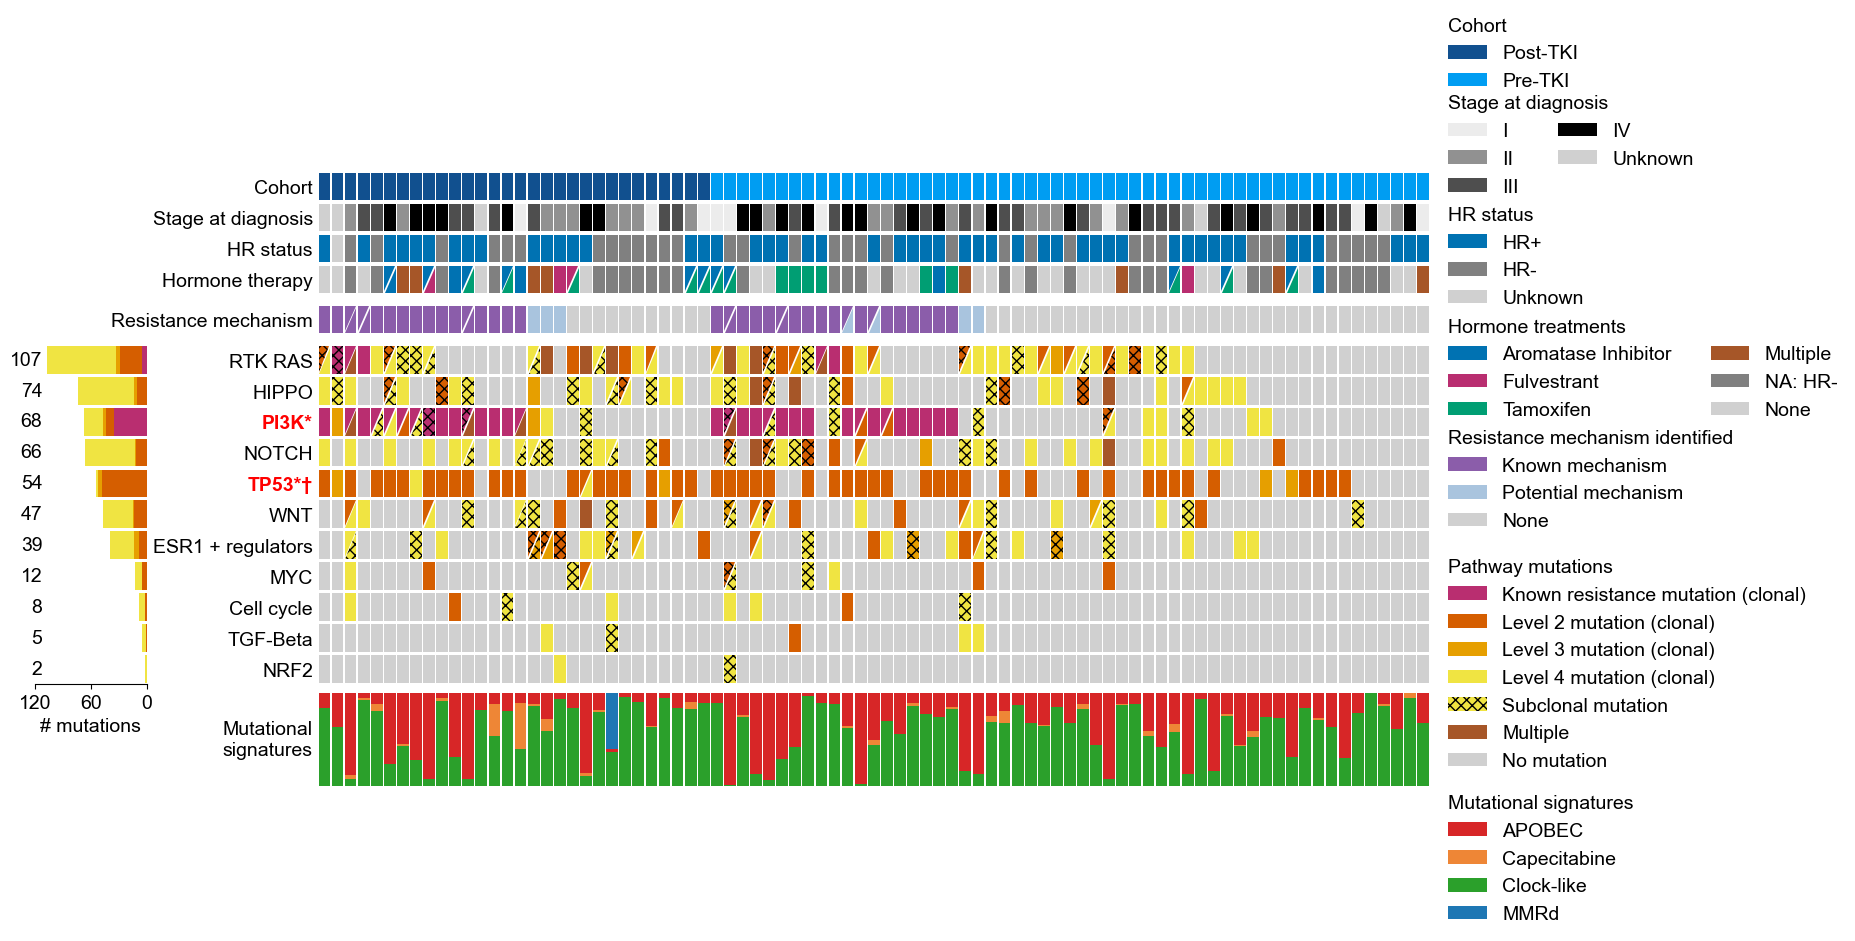

In [28]:
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Arial'

structure = [['Cohort', 'Stage at diagnosis', 'HR status', 'Hormone treatments'],
             ['Resistance mechanism'],
             ['Cancer pathways'],
             ['Mutational signatures']]

structure = [s[::-1] for s in structure][::-1]

resistance_plot.plot_comut(figsize = (18, 8), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.06, structure = structure, subplot_hspace = 0,
                           widths = [1, 10], wspace = 0.28)

# make MutSig significant pathway bold
for i in [6,8]:
    resistance_plot.axes['Cancer pathways'].get_yticklabels()[i].set_weight('bold')
    resistance_plot.axes['Cancer pathways'].get_yticklabels()[i].set_color('red')

first_axis = 'Mutational signatures' 
resistance_plot.axes[first_axis].set_xticks([])

resistance_plot.axes['Mutations'].set_xticks([0,60,120], [0,60,120])
resistance_plot.axes['Mutations'].set_yticks(np.arange(0.5,11), pathway_combined_counts_sums.loc[pathway_order], ha = 'right', va = 'center')
resistance_plot.axes['Mutations'].tick_params(axis='y', pad=-75)
resistance_plot.axes['Mutations'].get_yaxis().set_visible(True)
resistance_plot.axes['Mutations'].yaxis.tick_right()

resistance_plot.axes['Mutational signatures'].tick_params(axis = 'y', length = 0, labelleft = False)
resistance_plot.axes['Mutational signatures'].set_ylabel('Mutational\nsignatures', rotation = 'horizontal', ha = 'right', va = 'center')

cohort_legend_rename_dict = {'Exposed': 'Post-TKI', 'Non-exposed': 'Pre-TKI'}

stage_legend_order = ['I', 'II', 'III', 'IV', 'Unknown']

hrstatus_legend_rename_dict = {'HR Unknown': 'Unknown'}

hrstatus_legend_order = ['HR+', 'HR-', 'Unknown']

hormone_legend_order = ['Aromatase Inhibitor', 'Fulvestrant', 'Tamoxifen', 'Multiple', 'NA: HR-', 'None'] 

mech_legend_rename_dict = {'Absent': 'None'}
mech_legend_order = ['Known mechanism', 'Potential mechanism', 'Multiple', 'Absent']

pathway_legend_ignore = ['subclonal_1', 'subclonal_2', 'subclonal_3']

pathway_legend_rename_dict = {
    'clonal_1': 'Known resistance mutation (clonal)',
    'clonal_2': 'Level 2 mutation (clonal)',
    'clonal_3': 'Level 3 mutation (clonal)',
    'clonal_4': 'Level 4 mutation (clonal)',
    'subclonal_4': 'Subclonal mutation',
    'Absent': 'No mutation'
}

pathway_legend_order = [
    'Known resistance mutation (clonal)', 'Level 2 mutation (clonal)', 'Level 3 mutation (clonal)', 'Level 4 mutation (clonal)',
    'Subclonal mutation', 'Multiple', 'No mutation'
]

resistance_plot.add_axis_legend(name = 'Cohort',
                                ncol = 1,
                                title = 'Cohort',
                                rename = cohort_legend_rename_dict,
                                loc = 'upper left',
                                bbox_to_anchor = (1,6.5))

resistance_plot.add_axis_legend(name = 'Stage at diagnosis',
                                ncol = 2,
                                title = 'Stage at diagnosis',
                                order = stage_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor = (1,5))

resistance_plot.add_axis_legend(name = 'HR status',
                                ncol = 1,
                                title = 'HR status',
                                order = hrstatus_legend_order,
                                rename = hrstatus_legend_rename_dict,
                                loc = 'upper left',
                                bbox_to_anchor = (1,2.4))

resistance_plot.add_axis_legend(name = 'Hormone treatments',
                                ncol = 2,
                                title = 'Hormone treatments',
                                order = hormone_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor = (1,-0.2))

resistance_plot.add_axis_legend(name = 'Resistance mechanism',
                                ncol = 1,
                                title = 'Resistance mechanism identified',
                                rename = mech_legend_rename_dict,
                                order = mech_legend_order,
                                loc = 'upper left',
                                bbox_to_anchor=(1,-2.5))

resistance_plot.add_axis_legend(name = 'Cancer pathways',
                                ncol = 1,
                                ignored_values = pathway_legend_ignore,
                                rename = pathway_legend_rename_dict,
                                order = pathway_legend_order,
                                title = 'Pathway mutations',
                                bbox_to_anchor=(1,0.42))

resistance_plot.add_axis_legend(name = 'Mutational signatures',
                                ncol = 1,
                                title = 'Mutational signatures',
                                loc = 'upper left',
                                bbox_to_anchor=(1,0.1))

plt.show()

In [29]:
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_unpaired.2024-03-22.pdf'), bbox_inches='tight')
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_unpaired.2024-03-22.png'), dpi=450, bbox_inches='tight')

## Pre-TKI only

In [30]:
participant_list = participant_cohort_sheet[participant_cohort_sheet['Cohort'] == 'Non-exposed'].index.tolist()

all_mutations_functional_pre = all_mutations_functional[all_mutations_functional['Patient_ID'].isin(participant_list)].copy()

H_counts_norm_pre = H_counts_norm.loc[participant_list,:].copy()

In [31]:
default_cols = ['sample', 'category', 'value']

# Add cohort
cohort_tmp = participant_cohort_sheet.loc[participant_list, ['Cohort']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                   'Cohort': 'value'})
cohort_tmp['category'] = 'Cohort'
cohort_mapping = {'Exposed': dark_blue, 'Non-exposed': light_blue}

# Add HR Status
hr_tmp = participant_cohort_sheet.loc[participant_list, ['hr_status']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                             'hr_status': 'value'})
hr_tmp['category'] = 'HR status'
hr_mapping = {'HR+': accessible_blue, 'HR-': darker_gray,
             'HR Unknown': silent_gray}

# Add Stage at Diagnosis
stage_tmp = participant_cohort_sheet.loc[participant_list, ['stage_initial']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                         'stage_initial': 'value'})
stage_tmp['category'] = 'Stage at diagnosis'
stage_mapping = {'I': stage_colors[1], 'II': stage_colors[6], 'III': stage_colors[10], 'IV': stage_colors[-1],
                'Unknown': silent_gray}

# Prior AI or hormone therapy
hormone_tmp = treatment_sheet[treatment_sheet['participant_id'].isin(participant_list) &
                         (treatment_sheet['AI'] | treatment_sheet['Fulvestrant'] | treatment_sheet['Hormone Therapy'] | treatment_sheet['Endocrine Therapy']) &
                         (treatment_sheet['timing_ann'] != 'after_sampling')].copy().rename(columns={'participant_id': 'sample', 'Regimen Name': 'value'})
hormone_tmp = hormone_tmp.merge(participant_cohort_sheet.loc[participant_list, ['hr_status']], how='outer', left_on='sample', right_index=True).reset_index(drop=True)
hormone_tmp.loc[((hormone_tmp['hr_status'] == 'HR-') & (hormone_tmp['value'].isnull())), 'value'] = 'NA: HR-'
hormone_tmp.loc[(((hormone_tmp['hr_status'] == 'HR+') | (hormone_tmp['hr_status'] == 'HR Unknown')
                 ) & (hormone_tmp['value'].isnull())), 'value'] = 'None'
hormone_tmp['category'] = 'Hormone therapy'

hormone_tmp['value'] = hormone_tmp['value'].replace({
    'Tamoxifen ': 'Tamoxifen', 'Tamoxifen/Trastuzumab': 'Tamoxifen',
    'Neratinib/Fulvestrant': 'Fulvestrant', 'Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Trastuzumab/Fulvestrant': 'Fulvestrant', 'Fulvestrant/Alpelisib/Trastuzumab': 'Fulvestrant', 'Lapatinib/Trastuzumab/Fulvestrant->Capecitabine': 'Fulvestrant', 'Lapatinib/Fulvestrant': 'Fulvestrant', 'Neratinib/Fulvestrant': 'Fulvestrant',
    'Letrozole/Trastuzumab/Pertuzumab': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab': 'Aromatase Inhibitor', 'Trastuzumab/Letrozole': 'Aromatase Inhibitor', 'Letrozole': 'Aromatase Inhibitor', 'Anastrozole': 'Aromatase Inhibitor', 'Anastrozole/Trastuzumab': 'Aromatase Inhibitor', 'Anastrozole/Letrozole': 'Aromatase Inhibitor', 'Exemestane/Trastuzumab': 'Aromatase Inhibitor', 'Exemestane/Everolimus': 'Aromatase Inhibitor', 'Exemestane': 'Aromatase Inhibitor', 'Abemaciclib/Letrozole/Trastuzumab': 'Aromatase Inhibitor', 'Aromatase Inhibitor/Trastuzumab': 'Aromatase Inhibitor', 'Docetaxel/Carboplatin/Trastuzumab/Letrozole': 'Aromatase Inhibitor', 'Exemestane/Trastuzumab': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab/BYL (PI3kinase inhibitor)': 'Aromatase Inhibitor',
    'Bicalutamide': 'Antiandrogen'
})

hormone_mapping = {'Tamoxifen': accessible_green,
                   'Fulvestrant': accessible_pink,
                   'Aromatase Inhibitor': accessible_blue,
                   'Antiandrogen': accessible_orange_l,
                   'NA: HR-': darker_gray,
                   'None': silent_gray}

In [32]:
# Known and potential mechanisms
mechs = all_mutations_functional_pre[(all_mutations_functional_pre['Hugo_Symbol'].isin(['ESR1', 'FGFR2', 'FGFR4'])) |
                                     (all_mutations_functional_pre['level_of_evidence'] == 1)].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

mechs['category'] = 'Resistance mechanism'
mechs['value'] = np.where(mechs['level_of_evidence'] == 1, 'Known mechanism', 'Potential mechanism')

mechs_mapping = dict(zip(['Potential mechanism', 'Known mechanism', 'Absent'],
                         [plt.cm.get_cmap('BuPu', 4)(1)[:3], plt.cm.get_cmap('BuPu', 4)(2)[:3], silent_gray]))

In [33]:
# MutSig significantly recurrently mutated pathways
sig_pwys_nonexposed[sig_pwys_nonexposed['combined_p_fdr'] < 0.1]

,combined_p,gene_0,p_0,gene_1,p_1,gene_2,p_2,gene_3,p_3,gene_4,...,p_80,gene_81,p_81,gene_82,p_82,gene_83,p_83,gene_84,p_84,combined_p_fdr
pathway,,,,,,,,,,,,,,,,,,,,,
TP53,3.101290e-11,TP53,1.000000e-16,ATM,0.429317,RPS6KA3,0.995856,MDM2,0.998065,CHEK2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.411419e-10


In [34]:
# All pathway mutations with evidence level
# Group these into pathways
pathway_combined = all_mutations_functional_pre[all_mutations_functional_pre['level_of_evidence'].isin([1,2,3,4])].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

pathway_combined['category'] = pathway_combined['gene_set'].replace({'TP53': 'TP53†', 'ESR1': 'ESR1 + regulators', 'Cell Cycle': 'Cell cycle'})
pathway_combined['value'] = pathway_combined['clonal_status'] + '_' + pathway_combined['level_of_evidence'].astype(int).astype(str)

level_colors = [accessible_pink, accessible_orange, accessible_orange_l, accessible_yellow]
pathway_mut_mapping = {}
for t, h in zip(['clonal', 'subclonal'], [None, 'xxx']):
    for l in ['1','2','3','4']:
        pathway_mut_mapping[t+'_'+l] = {'facecolor': level_colors[int(l)-1], 'hatch': h}

pathway_mut_mapping['Absent'] = silent_gray

# Pathway counts for side bar plot
pathway_combined_counts = pathway_combined.copy()
pathway_combined_counts = pathway_combined_counts.groupby(['category', 'level_of_evidence']).size().to_frame('n_muts').reset_index()

pathway_combined_counts_wide = pathway_combined_counts.pivot(index='category', columns='level_of_evidence', values='n_muts').fillna(0).reset_index()
pathway_combined_counts_sums = pathway_combined_counts.groupby('category')['n_muts'].sum()

pathway_order = pathway_combined_counts_sums.sort_values().index

In [35]:
mechs_sort_values = mechs[['sample', 'value', 'category']].\
    replace({'Known mechanism': 1, 'Potential mechanism': 2}).\
    sort_values('value').\
    drop_duplicates('sample').\
    rename(columns = {'value': 'mech'}).\
    set_index('sample')

# sort by strongest level of evidence across all pathways
replace_pathways = {p: len(pathway_order) - i for p, i in zip(pathway_order, np.arange(len(pathway_order)))}
pathway_sort_values = pathway_combined[['sample', 'category']].replace({**replace_pathways}).groupby(['sample'])['category'].min().reset_index().rename(columns={'category': 'pathway_priority'}).set_index('sample')

In [36]:
resistance_plot = comut.CoMut()

# Sort participants
participants_sorted = participant_cohort_sheet.loc[participant_list].join(mechs_sort_values).join(pathway_sort_values).sort_values(['Cohort', 'mech', 'pathway_priority']).index
participants_sorted_no_ONC = [p[3:] for p in participants_sorted]
participants_mod_dict = {p: n for p, n in zip(participants_sorted, participants_sorted_no_ONC)}

resistance_plot.samples = participants_sorted_no_ONC

resistance_plot.add_categorical_data(cohort_tmp.replace(participants_mod_dict),  
                                     name = 'Cohort',
                                     mapping=cohort_mapping)

resistance_plot.add_categorical_data(stage_tmp.replace(participants_mod_dict), 
                                     name = 'Stage at diagnosis',
                                     mapping=stage_mapping,
                                     value_order=['I', 'II', 'III', 'IV'])

resistance_plot.add_categorical_data(hr_tmp.replace(participants_mod_dict), 
                                     name = 'HR status',
                                     mapping=hr_mapping)

resistance_plot.add_categorical_data(hormone_tmp[default_cols].replace(participants_mod_dict), 
                                     name = 'Hormone treatments',
                                     mapping=hormone_mapping)

resistance_plot.add_categorical_data(mechs[default_cols].replace(participants_mod_dict),
                                     name = 'Resistance mechanism',
                                     priority = 'Known mechanism',
                                     mapping = mechs_mapping)

pathway_priority = [f'{x}_1' for x in ['clonal', 'subclonal']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['clonal', 'subclonal']]

resistance_plot.add_categorical_data(pathway_combined[default_cols].drop_duplicates().replace(participants_mod_dict),
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(pathway_combined_counts_wide,
                                  paired_name = 'Cancer pathways',
                                  name = 'Mutations',
                                  mapping = dict(zip([1,2,3,4],level_colors)),
                                  stacked = True,
                                  xlabel = '# mutations',
                                  position = 'left',
                                  bar_kwargs = {'height': 0.9})

resistance_plot.add_bar_data(H_counts_norm_pre.reset_index().rename(columns={'participant_id': 'sample'}).replace(participants_mod_dict), name = 'Mutational signatures', mapping = sig_color_dict, stacked = True, #bar_kwargs = bar_kwargs, 
                             ylabel = 'Mutational signatures')

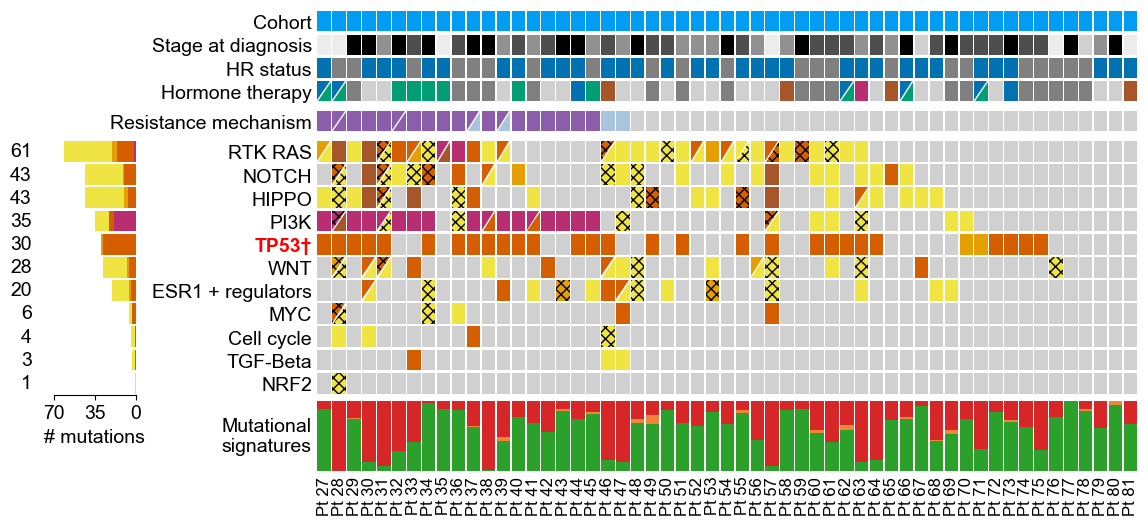

In [37]:
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Arial'

structure = [['Cohort', 'Stage at diagnosis', 'HR status', 'Hormone treatments'],
             ['Resistance mechanism'],
             ['Cancer pathways'],
             ['Mutational signatures']]

structure = [s[::-1] for s in structure][::-1]

resistance_plot.plot_comut(figsize = (14, 6), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.06, structure = structure, subplot_hspace = 0,
                           widths = [1, 10], wspace = 0.4)

# make MutSig significant pathway bold
resistance_plot.axes['Cancer pathways'].get_yticklabels()[6].set_weight('bold')
resistance_plot.axes['Cancer pathways'].get_yticklabels()[6].set_color('red')

first_axis = 'Mutational signatures'
ids = [f'Pt {27 + i}' for i in range(len(resistance_plot.samples))]
resistance_plot.axes[first_axis].set_xticklabels(ids, fontsize = 12)
pre_pt_id_dict = dict(zip(participants_sorted, ids))

resistance_plot.axes['Mutations'].set_xticks([0,35,70], [0,35,70])
resistance_plot.axes['Mutations'].set_yticks(np.arange(0.5,11), pathway_combined_counts_sums.loc[pathway_order], ha = 'right', va = 'center')
resistance_plot.axes['Mutations'].tick_params(axis='y', pad=-75)
resistance_plot.axes['Mutations'].get_yaxis().set_visible(True)
resistance_plot.axes['Mutations'].yaxis.tick_right()

resistance_plot.axes['Mutational signatures'].tick_params(axis = 'y', length = 0, labelleft = False)
resistance_plot.axes['Mutational signatures'].set_ylabel('Mutational\nsignatures', rotation = 'horizontal', ha = 'right', va = 'center')

plt.show()

In [38]:
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_pre.2024-03-22.pdf'), bbox_inches='tight')
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_pre.2024-03-22.png'), dpi=450, bbox_inches='tight')

## Post-TKI only

In [39]:
participant_list = participant_cohort_sheet[participant_cohort_sheet['Cohort'] == 'Exposed'].index.tolist()

all_mutations_functional_post = all_mutations_functional[all_mutations_functional['Patient_ID'].isin(participant_list)].copy()

H_counts_norm_post = H_counts_norm.loc[participant_list,:].copy()

In [40]:
default_cols = ['sample', 'category', 'value']

# Add cohort
cohort_tmp = participant_cohort_sheet.loc[participant_list, ['Cohort']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                   'Cohort': 'value'})
cohort_tmp['category'] = 'Cohort'
cohort_mapping = {'Exposed': dark_blue, 'Non-exposed': light_blue}

# Add HR Status
hr_tmp = participant_cohort_sheet.loc[participant_list, ['hr_status']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                             'hr_status': 'value'})
hr_tmp['category'] = 'HR status'
hr_mapping = {'HR+': accessible_blue, 'HR-': darker_gray,
             'HR Unknown': silent_gray}

# Add Stage at Diagnosis
stage_tmp = participant_cohort_sheet.loc[participant_list, ['stage_initial']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                                         'stage_initial': 'value'})
stage_tmp['category'] = 'Stage at diagnosis'
stage_mapping = {'I': stage_colors[1], 'II': stage_colors[6], 'III': stage_colors[10], 'IV': stage_colors[-1],
                'Unknown': silent_gray}

# Prior AI or hormone therapy
hormone_tmp = treatment_sheet[treatment_sheet['participant_id'].isin(participant_list) &
                         (treatment_sheet['AI'] | treatment_sheet['Fulvestrant'] | treatment_sheet['Hormone Therapy'] | treatment_sheet['Endocrine Therapy']) &
                         (treatment_sheet['timing_ann'] != 'after_sampling')].copy().rename(columns={'participant_id': 'sample', 'Regimen Name': 'value'})
hormone_tmp = hormone_tmp.merge(participant_cohort_sheet.loc[participant_list, ['hr_status']], how='outer', left_on='sample', right_index=True).reset_index(drop=True)
hormone_tmp.loc[((hormone_tmp['hr_status'] == 'HR-') & (hormone_tmp['value'].isnull())), 'value'] = 'NA: HR-'
hormone_tmp.loc[(((hormone_tmp['hr_status'] == 'HR+') | (hormone_tmp['hr_status'] == 'HR Unknown')
                 ) & (hormone_tmp['value'].isnull())), 'value'] = 'None'
hormone_tmp['category'] = 'Hormone therapy'

hormone_tmp['value'] = hormone_tmp['value'].replace({
    'Tamoxifen ': 'Tamoxifen', 'Tamoxifen/Trastuzumab': 'Tamoxifen',
    'Neratinib/Fulvestrant': 'Fulvestrant', 'Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Fulvestrant/Trastuzumab': 'Fulvestrant', 'Abemaciclib/Trastuzumab/Fulvestrant': 'Fulvestrant', 'Fulvestrant/Alpelisib/Trastuzumab': 'Fulvestrant', 'Lapatinib/Trastuzumab/Fulvestrant->Capecitabine': 'Fulvestrant', 'Lapatinib/Fulvestrant': 'Fulvestrant', 'Neratinib/Fulvestrant': 'Fulvestrant',
    'Letrozole/Trastuzumab/Pertuzumab': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab': 'Aromatase Inhibitor', 'Trastuzumab/Letrozole': 'Aromatase Inhibitor', 'Letrozole': 'Aromatase Inhibitor', 'Anastrozole': 'Aromatase Inhibitor', 'Anastrozole/Trastuzumab': 'Aromatase Inhibitor', 'Anastrozole/Letrozole': 'Aromatase Inhibitor', 'Exemestane/Trastuzumab': 'Aromatase Inhibitor', 'Exemestane/Everolimus': 'Aromatase Inhibitor', 'Exemestane': 'Aromatase Inhibitor', 'Abemaciclib/Letrozole/Trastuzumab': 'Aromatase Inhibitor', 'Aromatase Inhibitor/Trastuzumab': 'Aromatase Inhibitor', 'Docetaxel/Carboplatin/Trastuzumab/Letrozole': 'Aromatase Inhibitor', 'Exemestane/Trastuzumab': 'Aromatase Inhibitor', 'Letrozole/Trastuzumab/BYL (PI3kinase inhibitor)': 'Aromatase Inhibitor',
    'Bicalutamide': 'Antiandrogen'
})

hormone_mapping = {'Tamoxifen': accessible_green,
                   'Fulvestrant': accessible_pink,
                   'Aromatase Inhibitor': accessible_blue,
                   'Antiandrogen': accessible_orange_l,
                   'NA: HR-': darker_gray,
                   'None': silent_gray}

In [41]:
# Known and potential mechanisms
mechs = all_mutations_functional_post[(all_mutations_functional_post['Hugo_Symbol'].isin(['ESR1', 'FGFR2', 'FGFR4'])) |
                                     (all_mutations_functional_post['level_of_evidence'] == 1)].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

mechs['category'] = 'Resistance mechanism'
mechs['value'] = np.where(mechs['level_of_evidence'] == 1, 'Known mechanism', 'Potential mechanism')

mechs_mapping = dict(zip(['Potential mechanism', 'Known mechanism', 'Absent'],
                         [plt.cm.get_cmap('BuPu', 4)(1)[:3], plt.cm.get_cmap('BuPu', 4)(2)[:3], silent_gray]))

In [42]:
# MutSig significantly recurrently mutated pathways
sig_pwys_exposed[sig_pwys_exposed['combined_p_fdr'] < 0.1]

,combined_p,gene_0,p_0,gene_1,p_1,gene_2,p_2,gene_3,p_3,gene_4,...,p_80,gene_81,p_81,gene_82,p_82,gene_83,p_83,gene_84,p_84,combined_p_fdr
pathway,,,,,,,,,,,,,,,,,,,,,
PI3K,3.103742e-06,PIK3CA,1.110223e-16,PTEN,0.006458,TSC2,0.020370,RPS6KB1,0.028102,PPP2R1A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.707058e-05
TP53,2.553057e-13,TP53,1.000000e-16,ATM,0.005109,CHEK2,0.355887,RPS6KA3,0.999258,MDM4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.808362e-12


In [43]:
# All pathway mutations with evidence level
# Group these into pathways
pathway_combined = all_mutations_functional_post[all_mutations_functional_post['level_of_evidence'].isin([1,2,3,4])].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

pathway_combined['category'] = pathway_combined['gene_set'].replace({'TP53': 'TP53*', 'PI3K': 'PI3K*', 'ESR1': 'ESR1 + regulators', 'Cell Cycle': 'Cell cycle'})
pathway_combined['value'] = pathway_combined['clonal_status'] + '_' + pathway_combined['level_of_evidence'].astype(int).astype(str)

level_colors = [accessible_pink, accessible_orange, accessible_orange_l, accessible_yellow]
pathway_mut_mapping = {}
for t, h in zip(['clonal', 'subclonal'], [None, 'xxx']):
    for l in ['1','2','3','4']:
        pathway_mut_mapping[t+'_'+l] = {'facecolor': level_colors[int(l)-1], 'hatch': h}

pathway_mut_mapping['Absent'] = silent_gray

# Pathway counts for side bar plot
pathway_combined_counts = pathway_combined.copy()
pathway_combined_counts = pathway_combined_counts.groupby(['category', 'level_of_evidence']).size().to_frame('n_muts').reset_index()

pathway_combined_counts_wide = pathway_combined_counts.pivot(index='category', columns='level_of_evidence', values='n_muts').fillna(0).reset_index()
pathway_combined_counts_sums = pathway_combined_counts.groupby('category')['n_muts'].sum()

pathway_order = pathway_combined_counts_sums.sort_values().index

In [44]:
mechs_sort_values = mechs[['sample', 'value', 'category']].\
    replace({'Known mechanism': 1, 'Potential mechanism': 2}).\
    sort_values('value').\
    drop_duplicates('sample').\
    rename(columns = {'value': 'mech'}).\
    set_index('sample')

# sort by strongest level of evidence across all pathways
replace_pathways = {p: len(pathway_order) - i for p, i in zip(pathway_order, np.arange(len(pathway_order)))}
pathway_sort_values = pathway_combined[['sample', 'category']].replace({**replace_pathways}).groupby(['sample'])['category'].min().reset_index().rename(columns={'category': 'pathway_priority'}).set_index('sample')

In [45]:
resistance_plot = comut.CoMut()

# Sort participants
participants_sorted = participant_cohort_sheet.loc[participant_list].join(mechs_sort_values).join(pathway_sort_values).sort_values(['Cohort', 'mech', 'pathway_priority']).index
participants_sorted_no_ONC = [p[3:] for p in participants_sorted]
participants_mod_dict = {p: n for p, n in zip(participants_sorted, participants_sorted_no_ONC)}

resistance_plot.samples = participants_sorted_no_ONC

resistance_plot.add_categorical_data(cohort_tmp.replace(participants_mod_dict),  
                                     name = 'Cohort',
                                     mapping=cohort_mapping)

resistance_plot.add_categorical_data(stage_tmp.replace(participants_mod_dict), 
                                     name = 'Stage at diagnosis',
                                     mapping=stage_mapping,
                                     value_order=['I', 'II', 'III', 'IV'])

resistance_plot.add_categorical_data(hr_tmp.replace(participants_mod_dict), 
                                     name = 'HR status',
                                     mapping=hr_mapping)

resistance_plot.add_categorical_data(hormone_tmp[default_cols].replace(participants_mod_dict), 
                                     name = 'Hormone treatments',
                                     mapping=hormone_mapping)

resistance_plot.add_categorical_data(mechs[default_cols].replace(participants_mod_dict),
                                     name = 'Resistance mechanism',
                                     priority = 'Known mechanism',
                                     mapping = mechs_mapping)

pathway_priority = [f'{x}_1' for x in ['clonal', 'subclonal']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['clonal', 'subclonal']]

resistance_plot.add_categorical_data(pathway_combined[default_cols].drop_duplicates().replace(participants_mod_dict),
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(pathway_combined_counts_wide,
                                  paired_name = 'Cancer pathways',
                                  name = 'Mutations',
                                  mapping = dict(zip([1,2,3,4],level_colors)),
                                  stacked = True,
                                  xlabel = '# mutations',
                                  position = 'left',
                                  bar_kwargs = {'height': 0.9})

resistance_plot.add_bar_data(H_counts_norm_post.reset_index().rename(columns={'participant_id': 'sample'}).replace(participants_mod_dict), name = 'Mutational signatures', mapping = sig_color_dict, stacked = True, #bar_kwargs = bar_kwargs, 
                             ylabel = 'Mutational signatures')

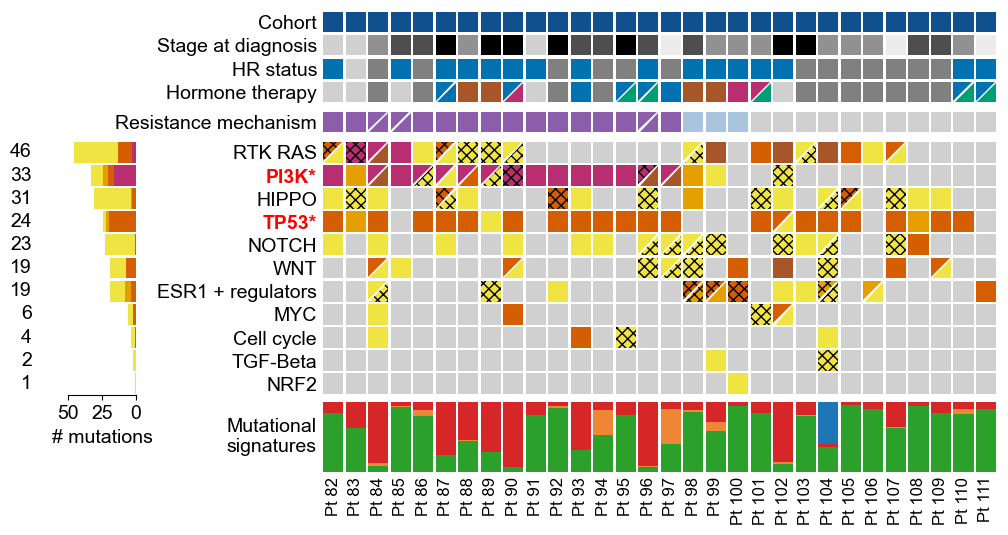

In [46]:
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Arial'

structure = [['Cohort', 'Stage at diagnosis', 'HR status', 'Hormone treatments'],
             ['Resistance mechanism'],
             ['Cancer pathways'],
             ['Mutational signatures']]

structure = [s[::-1] for s in structure][::-1]

resistance_plot.plot_comut(figsize = (12, 6), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.06, structure = structure, subplot_hspace = 0,
                           widths = [1, 10], wspace = 0.5)

# make MutSig significant pathways bold
for i in [7,9]:
    resistance_plot.axes['Cancer pathways'].get_yticklabels()[i].set_weight('bold')
    resistance_plot.axes['Cancer pathways'].get_yticklabels()[i].set_color('red')

first_axis = 'Mutational signatures' 
ids = [f'Pt {82 + i}' for i in range(len(resistance_plot.samples))]
resistance_plot.axes[first_axis].set_xticklabels(ids, fontsize = 12)
post_pt_id_dict = dict(zip(participants_sorted, ids))

resistance_plot.axes['Mutations'].set_xticks([0,25,50], [0,25,50])
resistance_plot.axes['Mutations'].set_yticks(np.arange(0.5,11), pathway_combined_counts_sums.loc[pathway_order], ha = 'right', va = 'center')
resistance_plot.axes['Mutations'].tick_params(axis='y', pad=-75)
resistance_plot.axes['Mutations'].get_yaxis().set_visible(True)
resistance_plot.axes['Mutations'].yaxis.tick_right()

resistance_plot.axes['Mutational signatures'].tick_params(axis = 'y', length = 0, labelleft = False)
resistance_plot.axes['Mutational signatures'].set_ylabel('Mutational\nsignatures', rotation = 'horizontal', ha = 'right', va = 'center')

plt.show()

In [47]:
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_post.2024-03-22.pdf'), bbox_inches='tight')
resistance_plot.figure.savefig(os.path.join(results_folder, 'pathway_plot_post.2024-03-22.png'), dpi=450, bbox_inches='tight')

# Save mapping from ONC IDs to manuscript IDs for the brain met comuts

In [48]:
unpaired_pt_id_dict = pre_pt_id_dict | post_pt_id_dict
unpaired_pt_id_df = pd.DataFrame(unpaired_pt_id_dict.items(), columns = ['ONC ID', 'Manuscript ID'])
unpaired_pt_id_df.to_csv(os.path.join(results_folder, 'ONC_ID_to_Manuscript_ID_mapping_unpaired.txt'), sep = '\t', index = False)
print(results_folder)

unpaired_pt_id_df

../../results/2024-03-21_comut-updates


,ONC ID,Manuscript ID
0,ONC70422,Pt 27
1,ONC4963,Pt 28
2,ONC115929,Pt 29
3,ONC50589,Pt 30
4,ONC58349,Pt 31
...,...,...
80,ONC77838,Pt 107
81,ONC106549,Pt 108
82,ONC13790,Pt 109
83,ONC97178,Pt 110
